In [35]:
from sentimenter import sentimenter as slr
import re
import pandas as pd
import numpy as np
import os.path

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [37]:
from sklearn.cross_validation import train_test_split

from sklearn.externals import joblib

# Data Collection

In [3]:
companies = slr.get_companies()
companies['Ticker_symbol'] = companies['Ticker_symbol'].apply(lambda x: x.replace('.N', ''))
print companies.info()
companies.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 505 entries, 0 to 504
Data columns (total 8 columns):
Ticker_symbol              505 non-null object
Security                   505 non-null object
SEC_filings                505 non-null object
GICS_Sector                505 non-null object
GICS_Sub_Industry          505 non-null object
Address_of_Headquarters    505 non-null object
Date_first_added           305 non-null object
CIK                        505 non-null int64
dtypes: int64(1), object(7)
memory usage: 35.5+ KB
None


,Ticker_symbol,Security,SEC_filings,GICS_Sector,GICS_Sub_Industry,Address_of_Headquarters,Date_first_added,CIK
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",NaN,66740
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800
2,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152
3,ACN,Accenture plc,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373
4,ATVI,Activision Blizzard,reports,Information Technology,Home Entertainment Software,"Santa Monica, California",2015-08-31,718877


In [4]:
all_articles = slr.get_sentimentalized_articles(companies)
all_articles.info()

[]
(74775, 6) (74708, 10)
need to sentimentalize 0 symbols
Nothing updated
<class 'pandas.core.frame.DataFrame'>
Int64Index: 74708 entries, 0 to 118
Data columns (total 10 columns):
Article     74708 non-null object
Date        74708 non-null object
Symbol      74708 non-null object
Time        74708 non-null object
Title       74708 non-null object
Url         74708 non-null object
compound    74708 non-null float64
neg         74708 non-null float64
neu         74708 non-null float64
pos         74708 non-null float64
dtypes: float64(4), object(6)
memory usage: 6.3+ MB


In [5]:
quotes = slr.update_quotes(all_articles)
quotes.info()

Available symbol quotes:  443
New downloaded symbol quotes:  57
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367219 entries, 0 to 367218
Data columns (total 8 columns):
Date         367219 non-null object
Adj Close    352735 non-null float64
Close        367219 non-null float64
High         367219 non-null float64
Low          367219 non-null float64
Open         367219 non-null float64
Symbol       367219 non-null object
Volume       367219 non-null float64
dtypes: float64(6), object(2)
memory usage: 22.4+ MB


# Data preparation

In [6]:
# Change Time column to simple time format
all_articles.Time = all_articles.Time.apply(lambda x: re.search('[0-9]?[0-9]:[0-9]{1,2}', x).group(0))
# Convert Date to DateTime
all_articles['Date'] = pd.to_datetime(all_articles['Date'], format='%Y-%m-%d')
all_articles.head()

,Article,Date,Symbol,Time,Title,Url,compound,neg,neu,pos
0,MOSCOW Jan 17 Russia's biggest home electron...,2014-01-17,MMM,7:49,Russia's M.video says consumer confidence weak...,http://www.reuters.com//article/russia-mvideo-...,0.0516,0.049,0.901,0.051
1,By Lewis Krauskopf Diversified manufacture...,2014-01-30,MMM,9:44,"3M revenue growth slows, misses Wall Street ta...",http://www.reuters.com//article/us-3m-results-...,0.7096,0.037,0.896,0.067
2,By Lewis KrauskopfJan 30 Diversified manufac...,2014-01-30,MMM,9:42,"UPDATE 2-3M revenue growth slows, misses Wall ...",http://www.reuters.com//article/3m-results-idU...,0.7964,0.038,0.886,0.076
3,Jan 30 Diversified manufacturer 3M Co poste...,2014-01-30,MMM,7:39,Manufacturer 3M posts 11 percent rise in net i...,http://www.reuters.com//article/3m-results-idU...,0.7430,0.000,0.885,0.115
4,3M Co. has invested US$15 million in one of ...,2014-03-10,MMM,8:19,SINGAPORE PRESS-3M to lift N95 mask output at ...,http://www.reuters.com//article/singapore-pres...,0.4019,0.000,0.958,0.042


In [7]:
# Remove unwanted column
quotes = quotes.drop('Adj Close', axis=1)
# Convert Date to DateTime
quotes['Date'] = pd.to_datetime(quotes['Date'], format='%Y-%m-%d')
quotes.head()

,Date,Close,High,Low,Open,Symbol,Volume
0,2014-01-02,35.53,36.11,35.47,36.05,AEE,1394264.0
1,2014-01-03,35.40,35.69,35.22,35.63,AEE,1206534.0
2,2014-01-06,35.76,35.82,35.42,35.70,AEE,2837469.0
3,2014-01-07,36.22,36.25,35.81,35.81,AEE,1653721.0
4,2014-01-08,35.94,36.19,35.80,36.14,AEE,1618538.0


In [8]:
articles = all_articles.copy()
# create a new dataframe with just sentiments
articles = articles[['Date', 'Symbol', 'compound', 'neg', 'neu', 'pos']]

In [9]:
# pivot multiple news to a single one by averaging its score
articles = pd.pivot_table(articles,
                          index=['Date', 'Symbol'],
                          values=['compound', 'neg', 'neu', 'pos'],
                          aggfunc=np.average).reset_index()
articles.head()

,Date,Symbol,compound,neg,neu,pos
0,2014-01-01,AAL,0.97710,0.035000,0.897,0.068000
1,2014-01-01,AZO,0.99110,0.055000,0.836,0.109000
2,2014-01-01,BRKB,-0.99340,0.122000,0.822,0.056000
3,2014-01-01,CPB,-0.17790,0.079500,0.864,0.056000
4,2014-01-02,AAPL,0.95785,0.031833,0.876,0.092333


In [10]:
# check whether we have news and quotes for same number of symbols
print "We have {} symbols in articles and {} symbols in quotes".format(
    len(articles['Symbol'].unique()), len(quotes['Symbol'].unique()))
print "shape of articles: {}, shape of quotes: {}".format(articles.shape, quotes.shape)

We have 500 symbols in articles and 500 symbols in quotes
shape of articles: (30294, 6), shape of quotes: (367219, 7)


In [11]:
# join articles to quotes
quotes_articles = quotes.set_index(['Date', 'Symbol']).join(
    articles.set_index(['Date', 'Symbol']), rsuffix='r').reset_index()
quotes_articles.head()

,Date,Symbol,Close,High,Low,Open,Volume,compound,neg,neu,pos
0,2014-01-02,AEE,35.53,36.11,35.47,36.05,1394264.0,NaN,NaN,NaN,NaN
1,2014-01-03,AEE,35.40,35.69,35.22,35.63,1206534.0,NaN,NaN,NaN,NaN
2,2014-01-06,AEE,35.76,35.82,35.42,35.70,2837469.0,NaN,NaN,NaN,NaN
3,2014-01-07,AEE,36.22,36.25,35.81,35.81,1653721.0,NaN,NaN,NaN,NaN
4,2014-01-08,AEE,35.94,36.19,35.80,36.14,1618538.0,NaN,NaN,NaN,NaN


In [12]:
quotes_articles['Next_Close'] = quotes_articles['Close'].shift(-1) # used fo calculating next day's slope
quotes_articles['Next_Open'] = quotes_articles['Open'].shift(-1)   # for some possible prediction
quotes_articles['Prev_Close'] = quotes_articles['Close'].shift(1)  # used fo calculating previous day's slope
quotes_articles.head()

,Date,Symbol,Close,High,Low,Open,Volume,compound,neg,neu,pos,Next_Close,Next_Open,Prev_Close
0,2014-01-02,AEE,35.53,36.11,35.47,36.05,1394264.0,NaN,NaN,NaN,NaN,35.40,35.63,NaN
1,2014-01-03,AEE,35.40,35.69,35.22,35.63,1206534.0,NaN,NaN,NaN,NaN,35.76,35.70,35.53
2,2014-01-06,AEE,35.76,35.82,35.42,35.70,2837469.0,NaN,NaN,NaN,NaN,36.22,35.81,35.40
3,2014-01-07,AEE,36.22,36.25,35.81,35.81,1653721.0,NaN,NaN,NaN,NaN,35.94,36.14,35.76
4,2014-01-08,AEE,35.94,36.19,35.80,36.14,1618538.0,NaN,NaN,NaN,NaN,36.04,36.02,36.22


In [13]:
# Since we did shift on the whole document we need to change first and last quote for each symbol
for symbol in quotes_articles['Symbol'].unique():
    min_date = quotes_articles[(quotes_articles['Symbol'] == symbol)].Date.min()
    max_date = quotes_articles[(quotes_articles['Symbol'] == symbol)].Date.max()
    quotes_articles.Prev_Close[(quotes_articles['Symbol'] == symbol) & (quotes_articles['Date'] == min_date)] = None
    quotes_articles.Prev_Close[(quotes_articles['Symbol'] == symbol) & (quotes_articles['Date'] == max_date)] = None
quotes_articles.head()

/home/ali/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ali/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Date,Symbol,Close,High,Low,Open,Volume,compound,neg,neu,pos,Next_Close,Next_Open,Prev_Close
0,2014-01-02,AEE,35.53,36.11,35.47,36.05,1394264.0,NaN,NaN,NaN,NaN,35.40,35.63,NaN
1,2014-01-03,AEE,35.40,35.69,35.22,35.63,1206534.0,NaN,NaN,NaN,NaN,35.76,35.70,35.53
2,2014-01-06,AEE,35.76,35.82,35.42,35.70,2837469.0,NaN,NaN,NaN,NaN,36.22,35.81,35.40
3,2014-01-07,AEE,36.22,36.25,35.81,35.81,1653721.0,NaN,NaN,NaN,NaN,35.94,36.14,35.76
4,2014-01-08,AEE,35.94,36.19,35.80,36.14,1618538.0,NaN,NaN,NaN,NaN,36.04,36.02,36.22


In [14]:
calculate_slopes = lambda x: pd.Series([
        x['Close'] - x['Prev_Close'],
        x['Next_Close'] - x['Close'],
        (x['Next_Close'] - x['Close']) - (x['Close'] - x['Prev_Close']),
    ])

In [15]:
tmp = quotes_articles.apply(calculate_slopes, axis=1)
tmp.columns = ['Prev_Slope', 'Next_Slope', 'Diff_Slope']
quotes_articles = pd.concat([quotes_articles, tmp], axis=1)

In [16]:
# simple select for quotes with articles
has_news = quotes_articles[(quotes_articles['compound'].notnull())]
has_news = has_news.dropna()
has_news.head()

,Date,Symbol,Close,High,Low,Open,Volume,compound,neg,neu,pos,Next_Close,Next_Open,Prev_Close,Prev_Slope,Next_Slope,Diff_Slope
355,2015-06-02,AEE,39.62,40.01,39.26,40.00,1481676.0,-0.033950,0.0545,0.924000,0.021500,39.31,39.51,40.22,-0.60,-0.31,0.29
390,2015-07-22,AEE,38.66,39.04,38.61,38.73,1354719.0,-0.979000,0.0910,0.892000,0.017000,38.27,38.55,38.70,-0.04,-0.39,-0.35
432,2015-09-21,AEE,40.82,41.06,40.39,40.52,1704133.0,-0.599400,0.0580,0.919000,0.024000,40.50,40.52,40.37,0.45,-0.32,-0.77
570,2016-04-08,AEE,48.78,51.00,48.70,49.40,4807348.0,0.839033,0.0000,0.872333,0.127667,48.68,48.86,49.16,-0.38,-0.10,0.28
592,2016-05-10,AEE,48.66,48.86,48.40,48.52,1366599.0,0.778300,0.0000,0.833000,0.167000,48.15,48.63,48.43,0.23,-0.51,-0.74


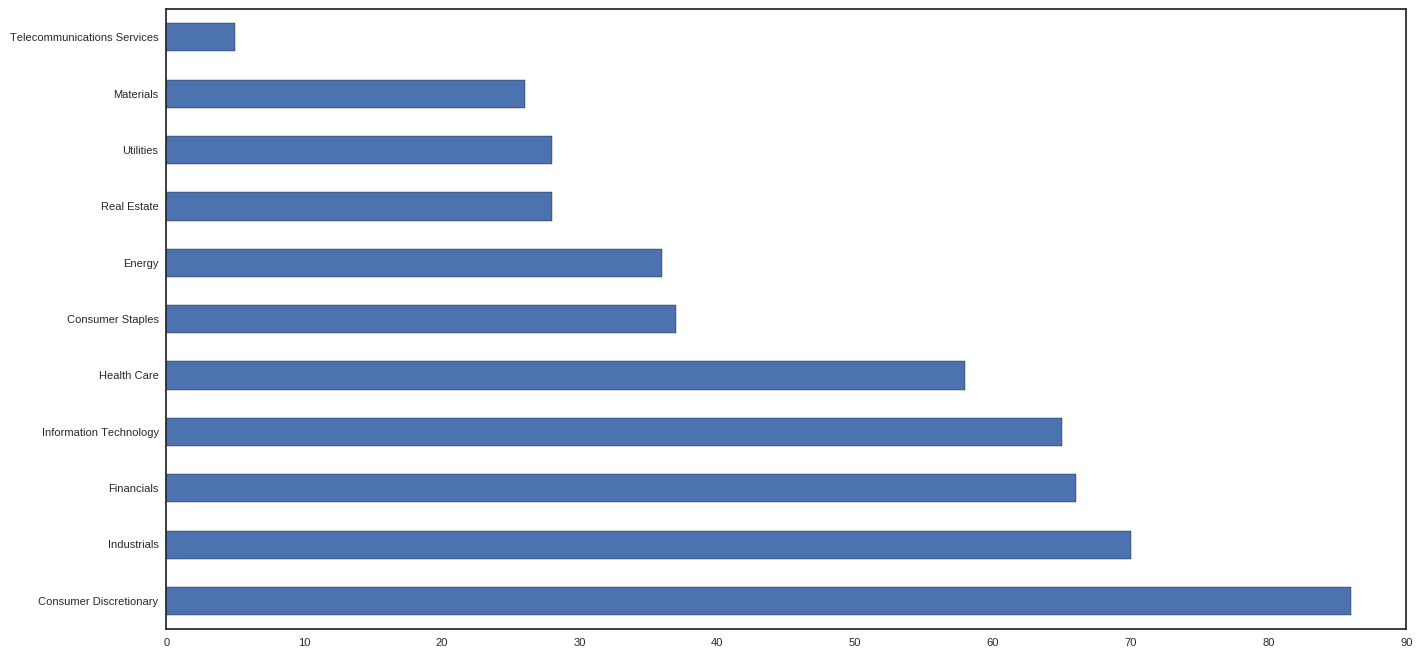

In [17]:
slr.set_style()
companies.GICS_Sector.value_counts().plot.barh(figsize=(16, 8))

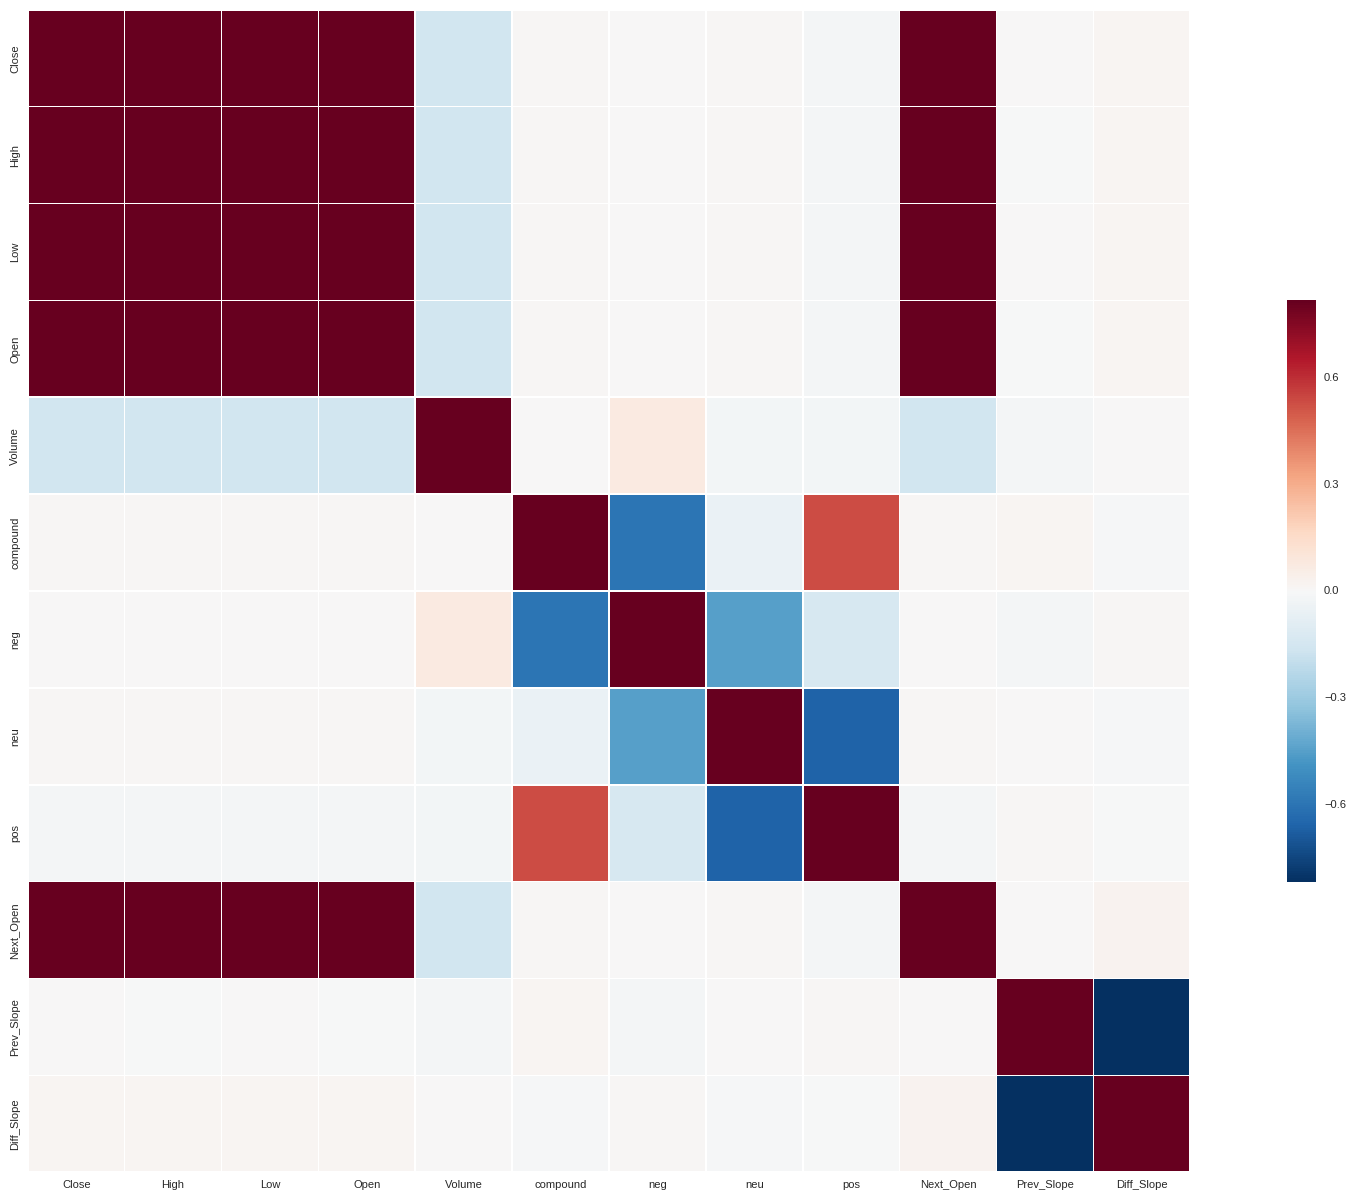

In [18]:
plt.figure(figsize=(25,15))
sns.heatmap(
    has_news[['Close', 'High', 'Low', 'Open', 'Volume',
              'compound', 'neg', 'neu', 'pos', 'Next_Open',
              'Prev_Slope', 'Diff_Slope']].corr(),
    vmax=.3,
    square=True, 
    linewidths=.5,
    cbar_kws={"shrink": .5})

In [19]:
x = has_news[['Close', 'High', 'Low', 'Open', 'Volume', 'compound',
              'neg', 'neu', 'pos', 'Next_Open', 'Prev_Slope']]
y = has_news['Diff_Slope']
x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.3)

# Modeling

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=-1, normalize=False) 

Mean cross validation score                       0.843836096682
Model socre                                       0.795887548297
Explained variance regression score               0.795953750091
Mean Absolute Error                               1.0716026523

score for test data                               0.960502748998
RidgeCV(alphas=[0.1, 0.5, 1.0, 5.0, 10.0, 100.0], cv=None, fit_intercept=True,
    gcv_mode=None, normalize=True, scoring=None, store_cv_values=False) 

Mean cross validation score                       0.446457529308
Model socre                                       0.589976228701
Explained variance regression score               0.590081259136
Mean Absolute Error                               1.37763377713

score for test data                               0.869805112658
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=No

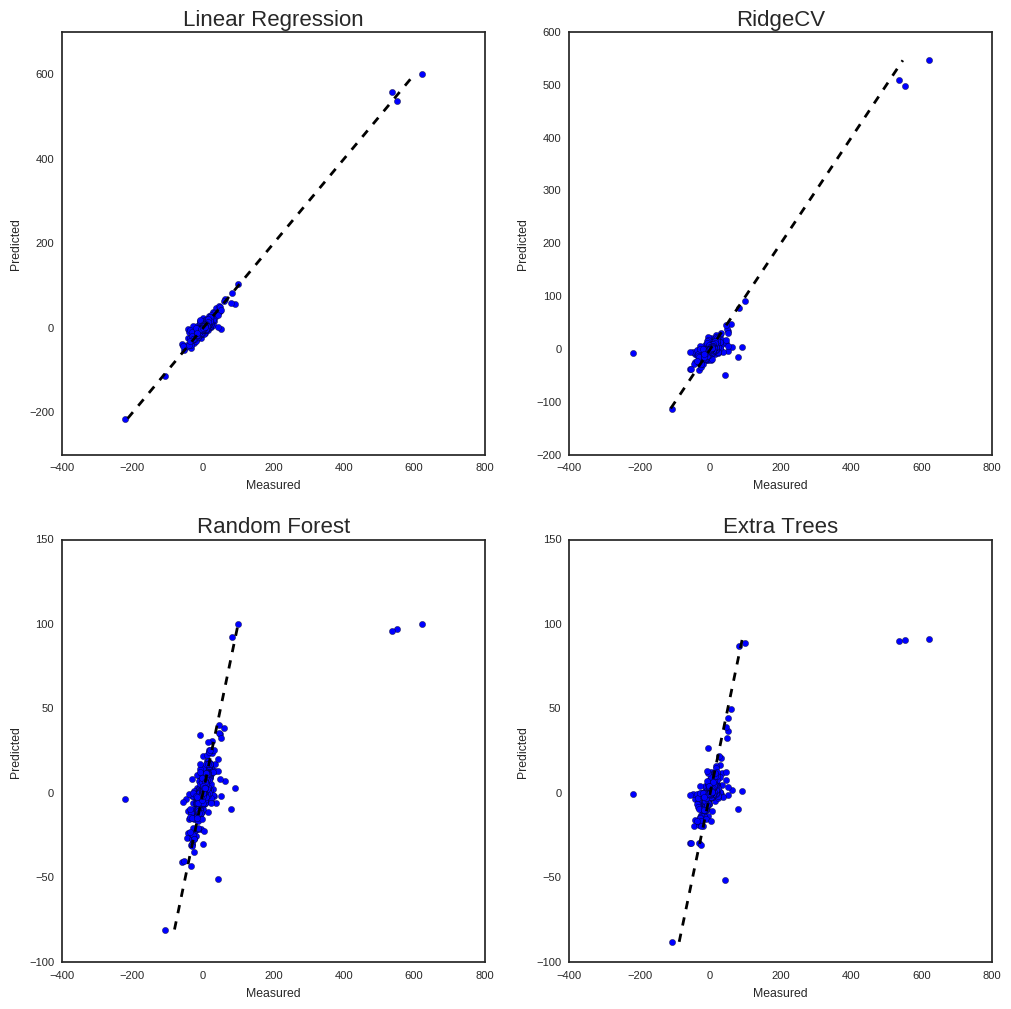

In [23]:
filename = 'datasets/models/all.sav'
all_dic = {}
if os.path.exists(filename):
    all_dic = joblib.load(filename)
else:
    all_dic['lr_model'], all_dic['lr_report'] = slr.linear_regression(x_train, y_train)
    all_dic['rd_model'], all_dic['rd_report'] = slr.ridge_cv(x_train, y_train)
    all_dic['rf_model'], all_dic['rf_report'] = slr.random_forest(x_train, y_train)
    all_dic['et_model'], all_dic['et_report'] = slr.extra_trees(x_train, y_train)

    all_dic['size'] = x.shape[0]
    joblib.dump(all_dic, filename)

slr.print_model_report(all_dic['lr_report'], 
                       model=all_dic['lr_model'], score=all_dic['lr_model'].score(x_test, y_test))
slr.print_model_report(all_dic['rd_report'], 
                       model=all_dic['rd_model'], score=all_dic['rd_model'].score(x_test, y_test))
slr.print_model_report(all_dic['rf_report'], 
                       model=all_dic['rf_model'], score=all_dic['rf_model'].score(x_test, y_test))
slr.print_model_report(all_dic['et_report'], 
                       model=all_dic['et_model'], score=all_dic['et_model'].score(x_test, y_test))

slr.plot_comparisions(y_test,
                  all_dic['lr_model'].predict(x_test),
                  all_dic['rd_model'].predict(x_test),
                  all_dic['rf_model'].predict(x_test),
                  all_dic['et_model'].predict(x_test)
                 )

In [24]:
sector_symbols = {}
for sector in companies.GICS_Sector.unique():
    sector_symbols[sector] = list(companies.Ticker_symbol[companies.GICS_Sector == sector])

Telecommunications Services
522


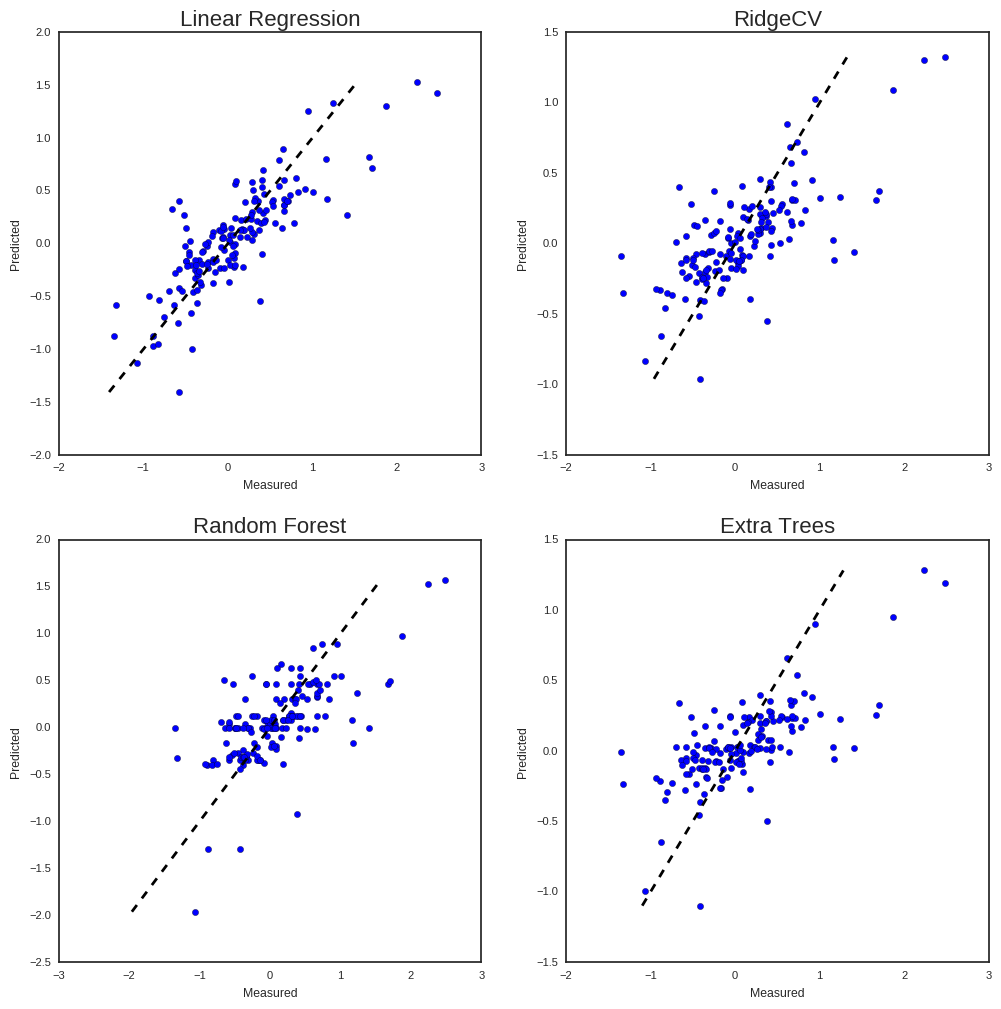

Industrials
3421


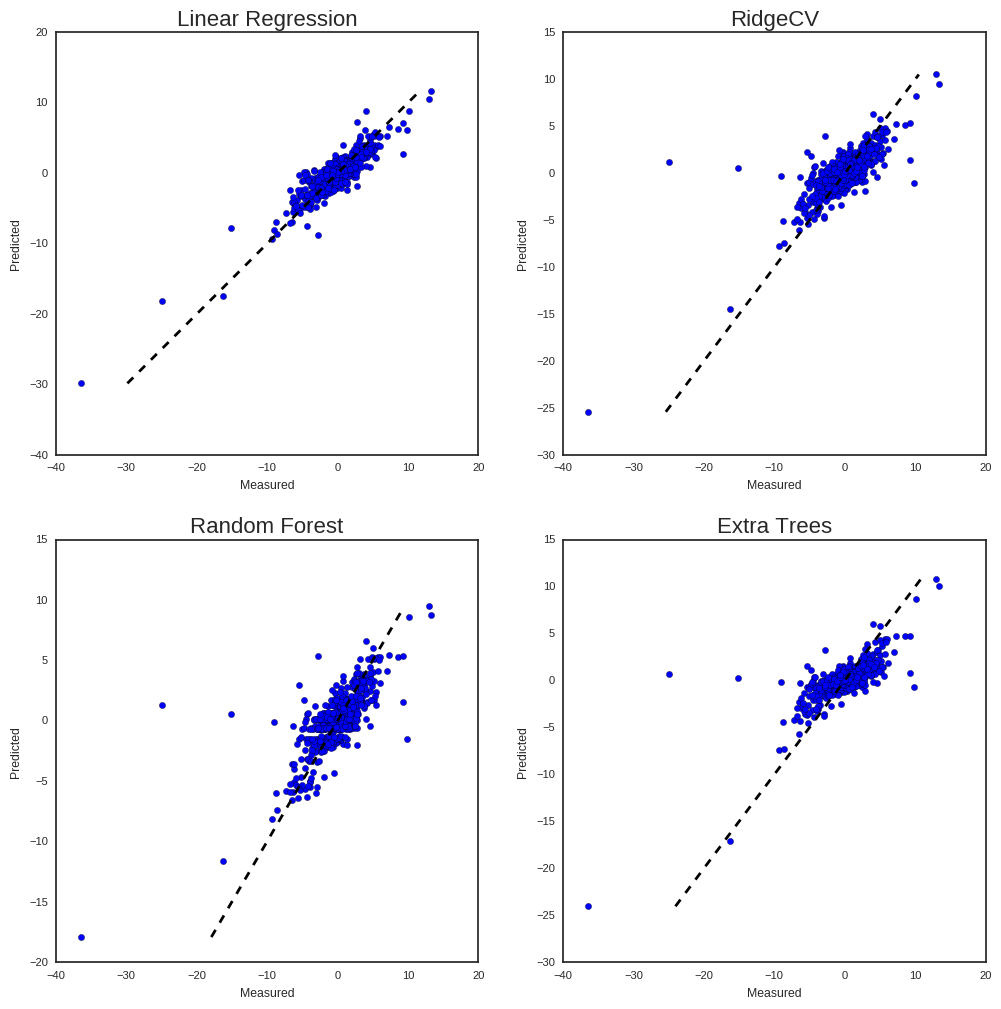

Consumer Discretionary
5381


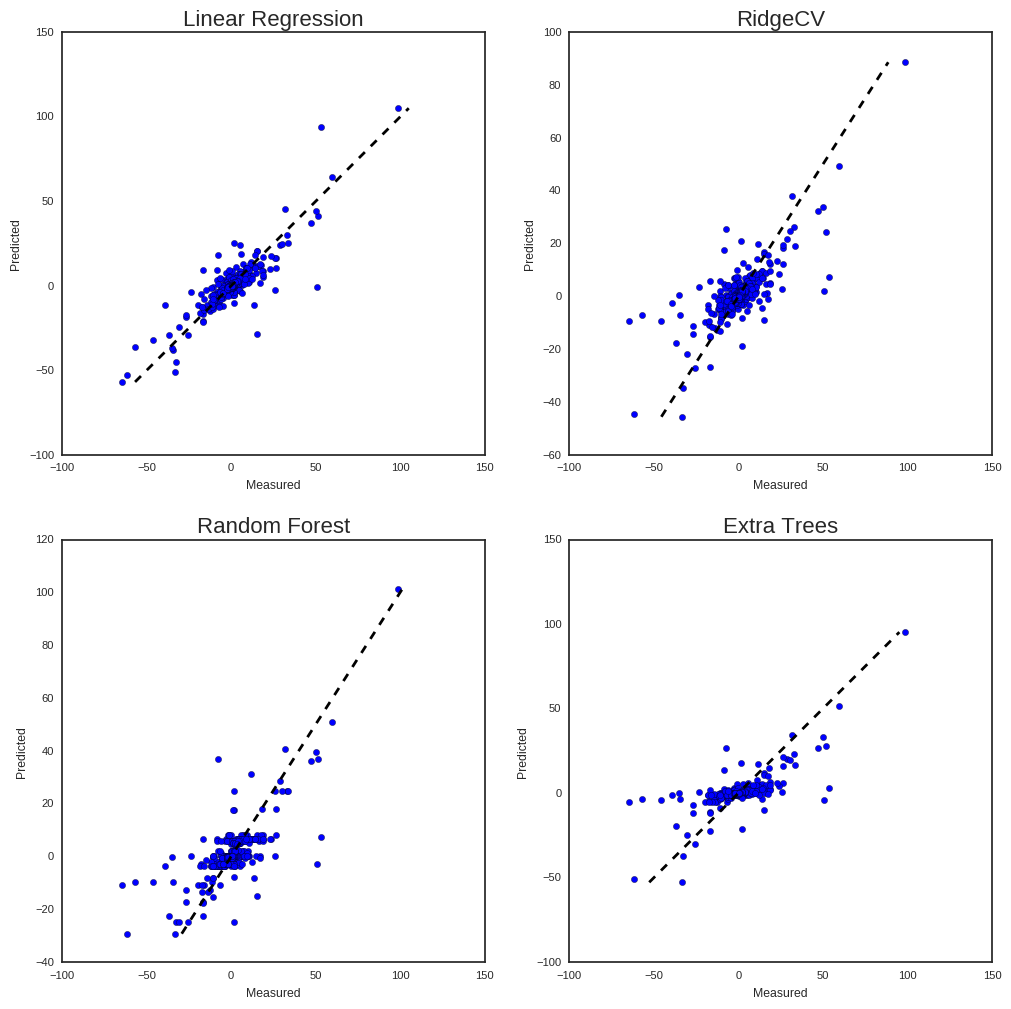

Utilities
526


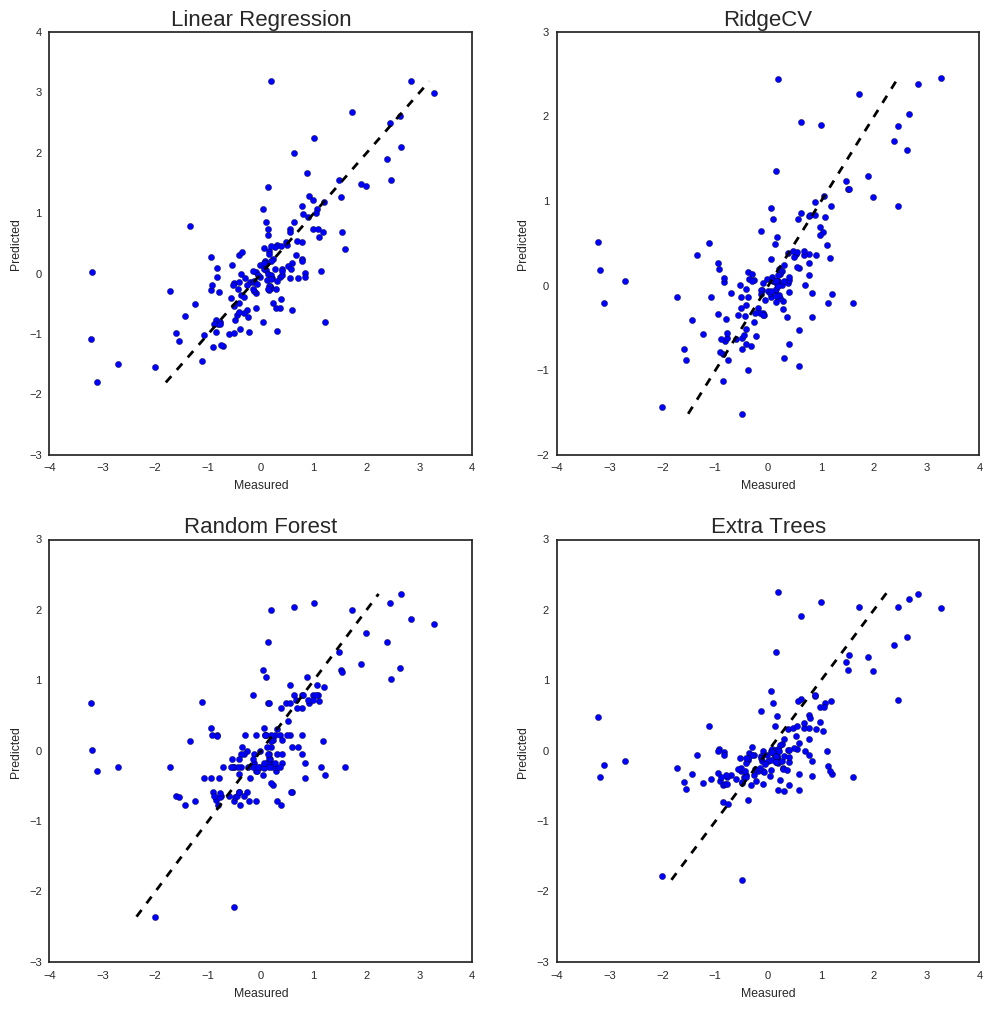

Consumer Staples
2113


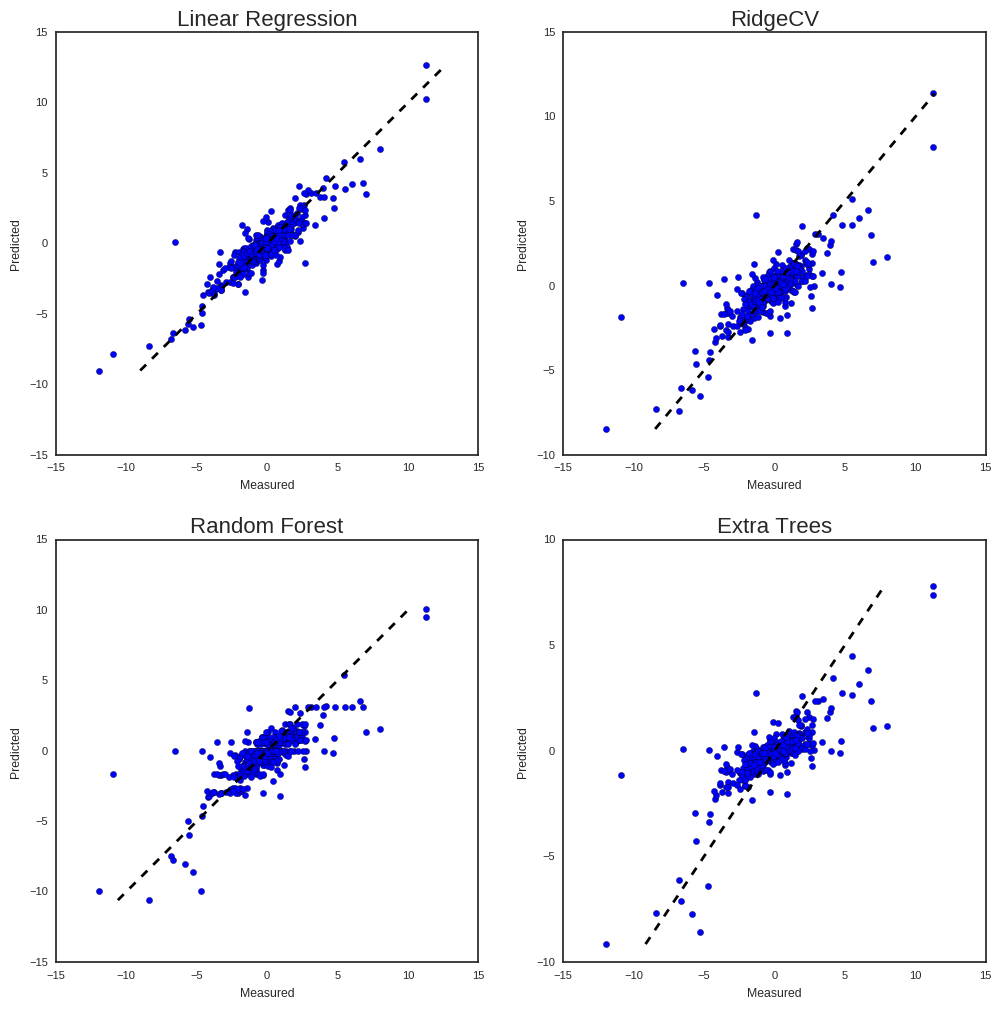

Health Care
3382


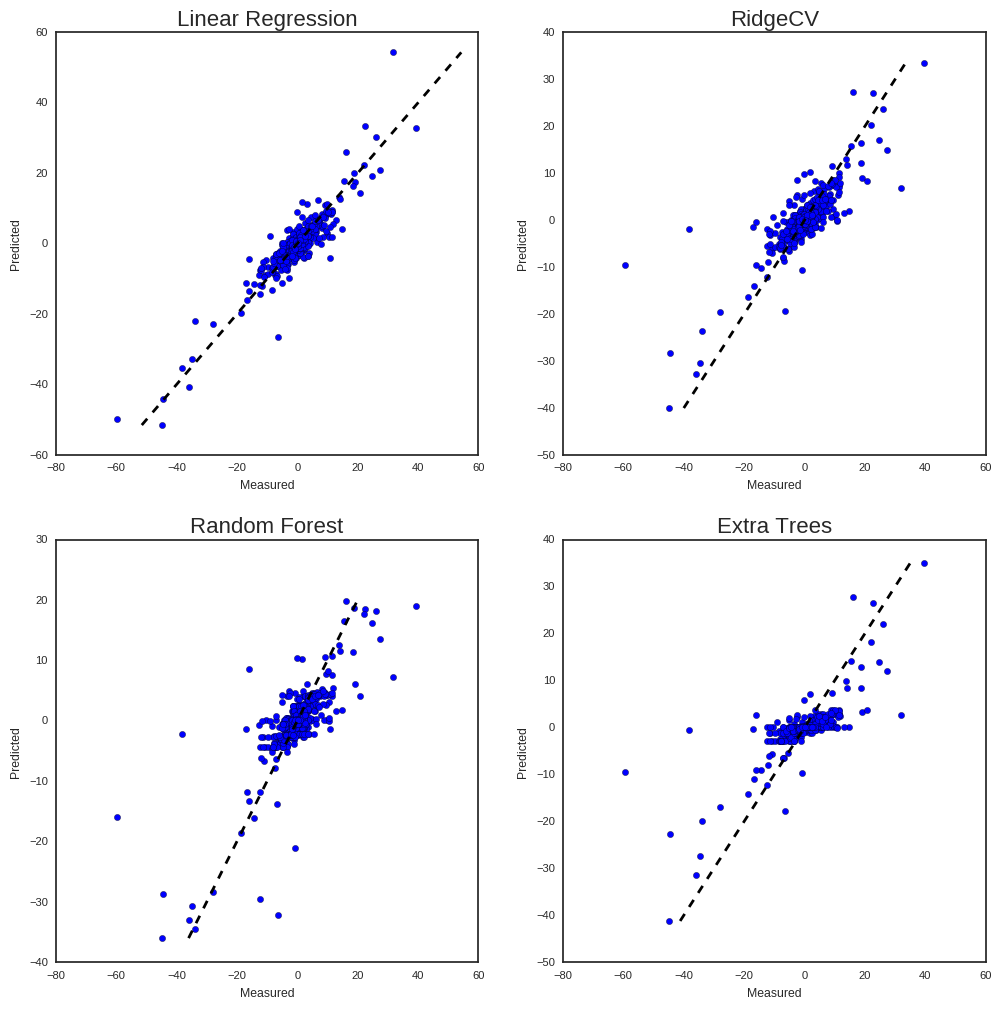

Materials
1073


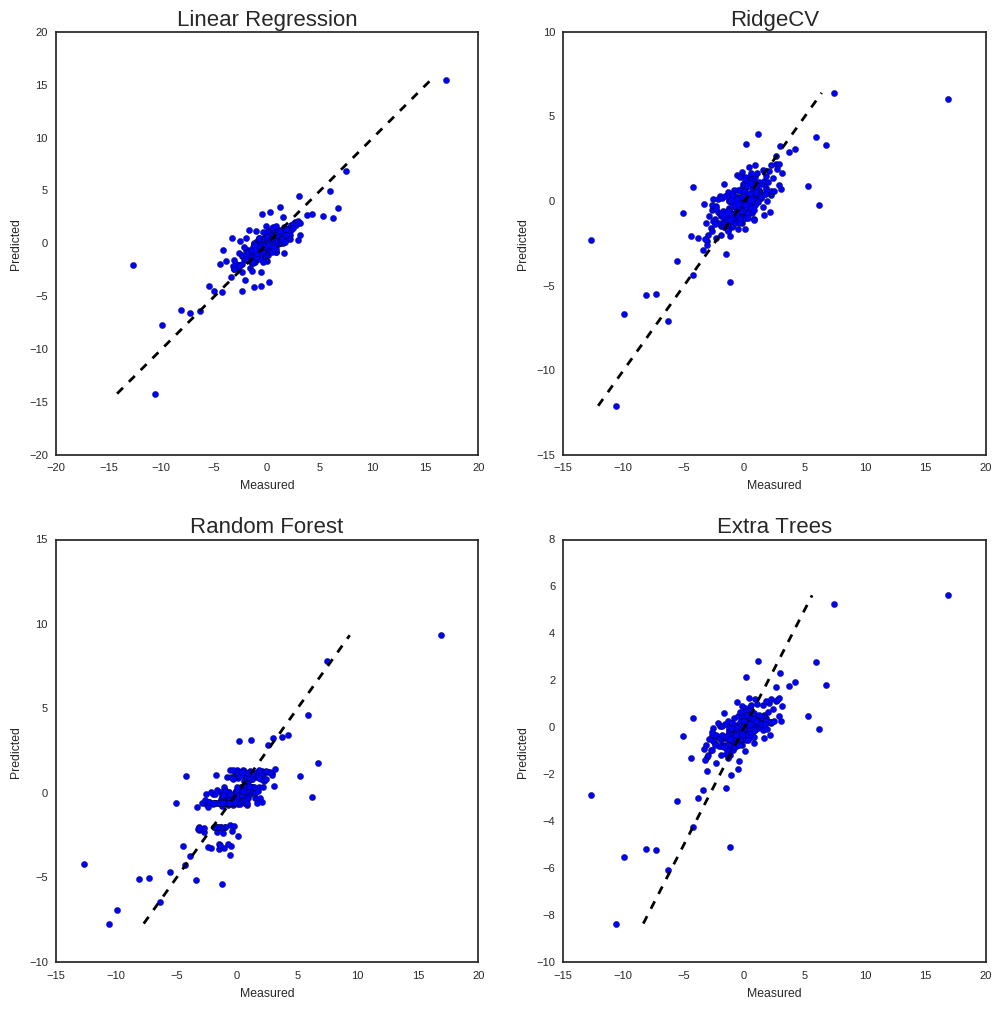

Information Technology
5239


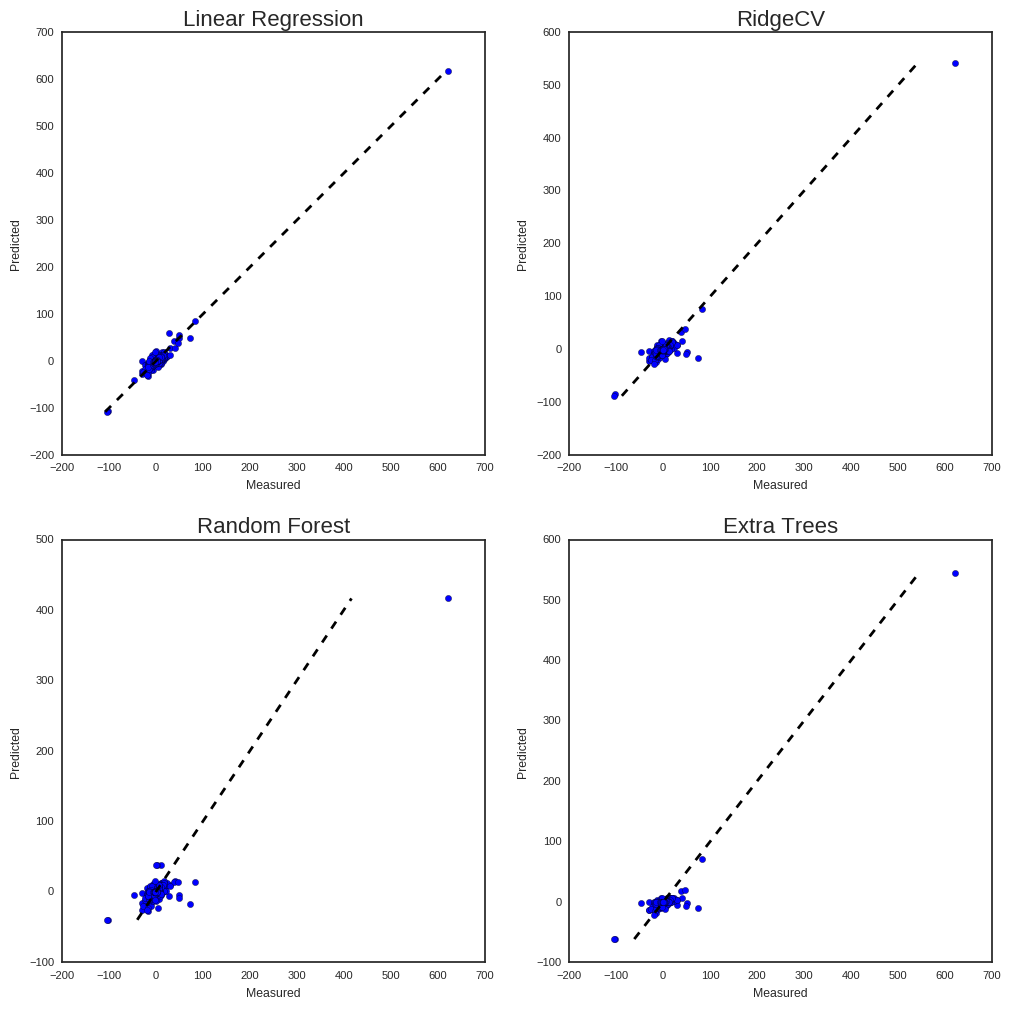

Real Estate
370


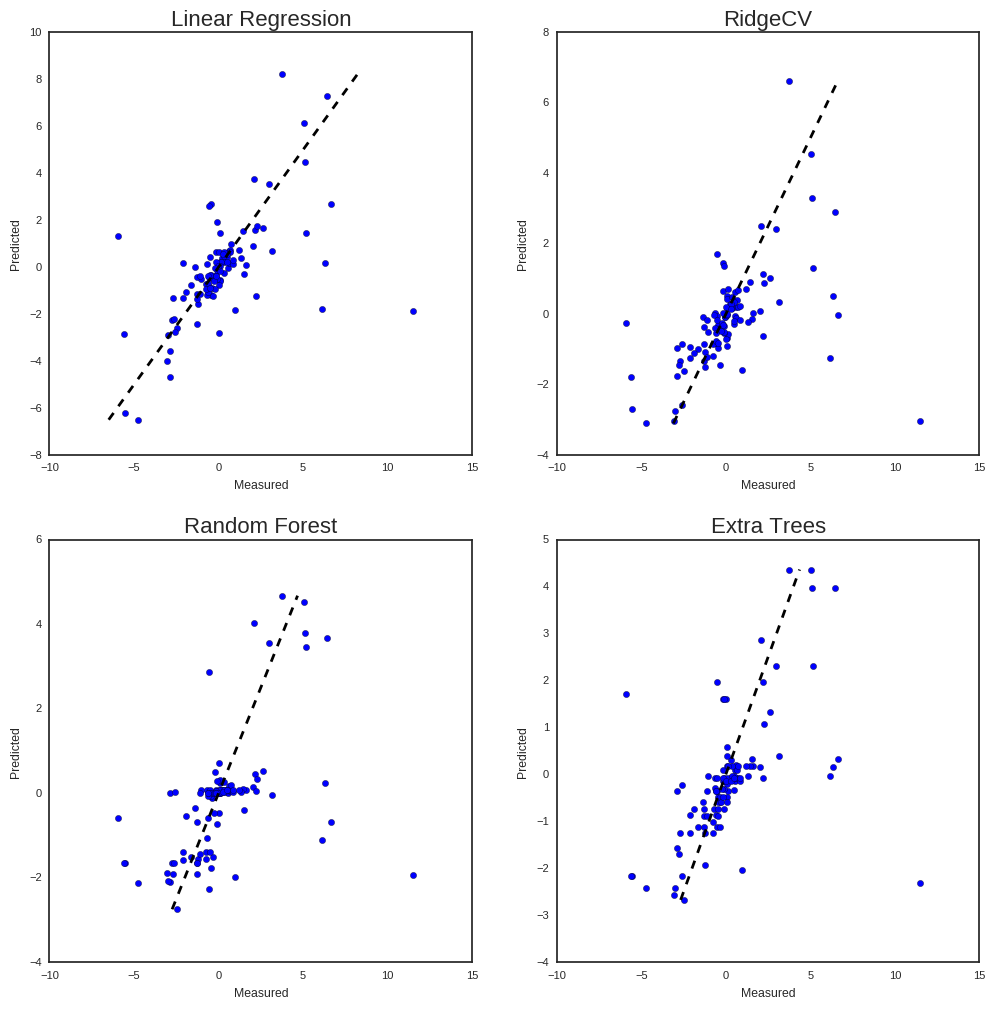

Energy
2242


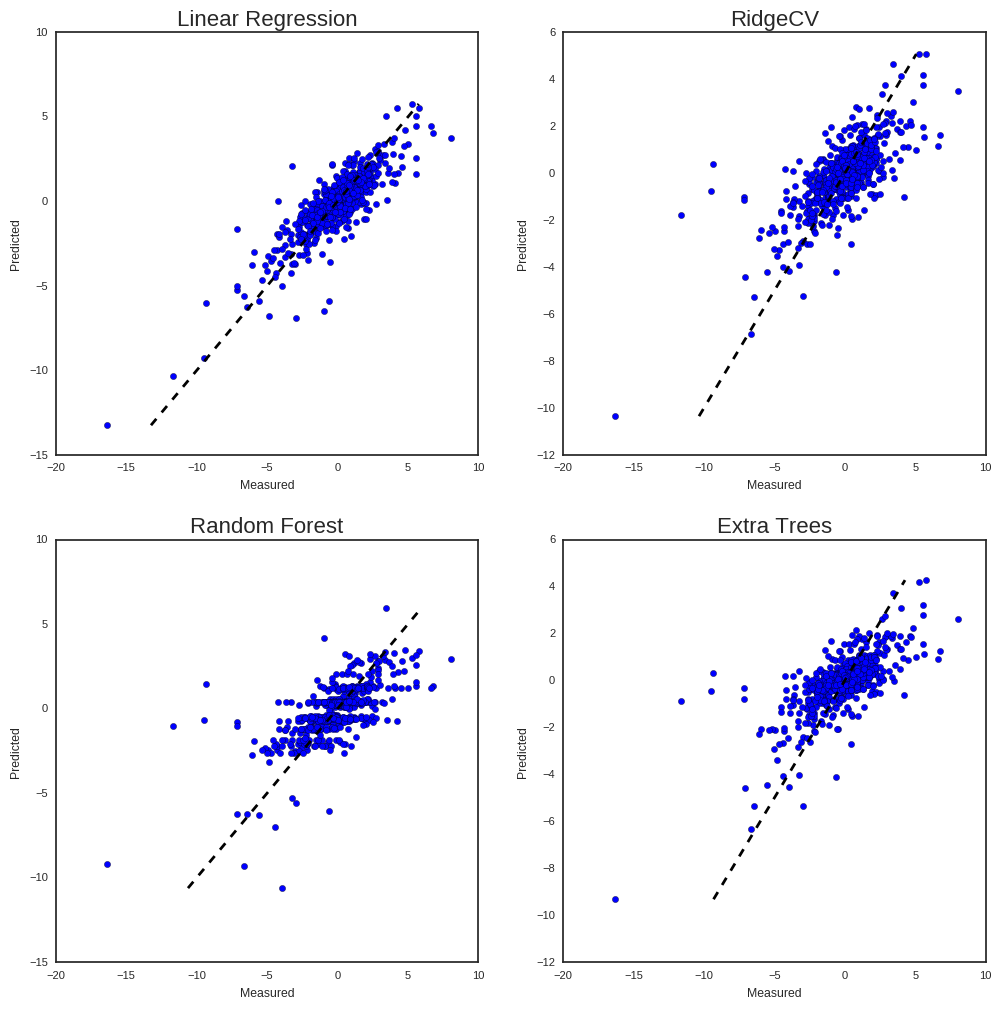

Financials
4355


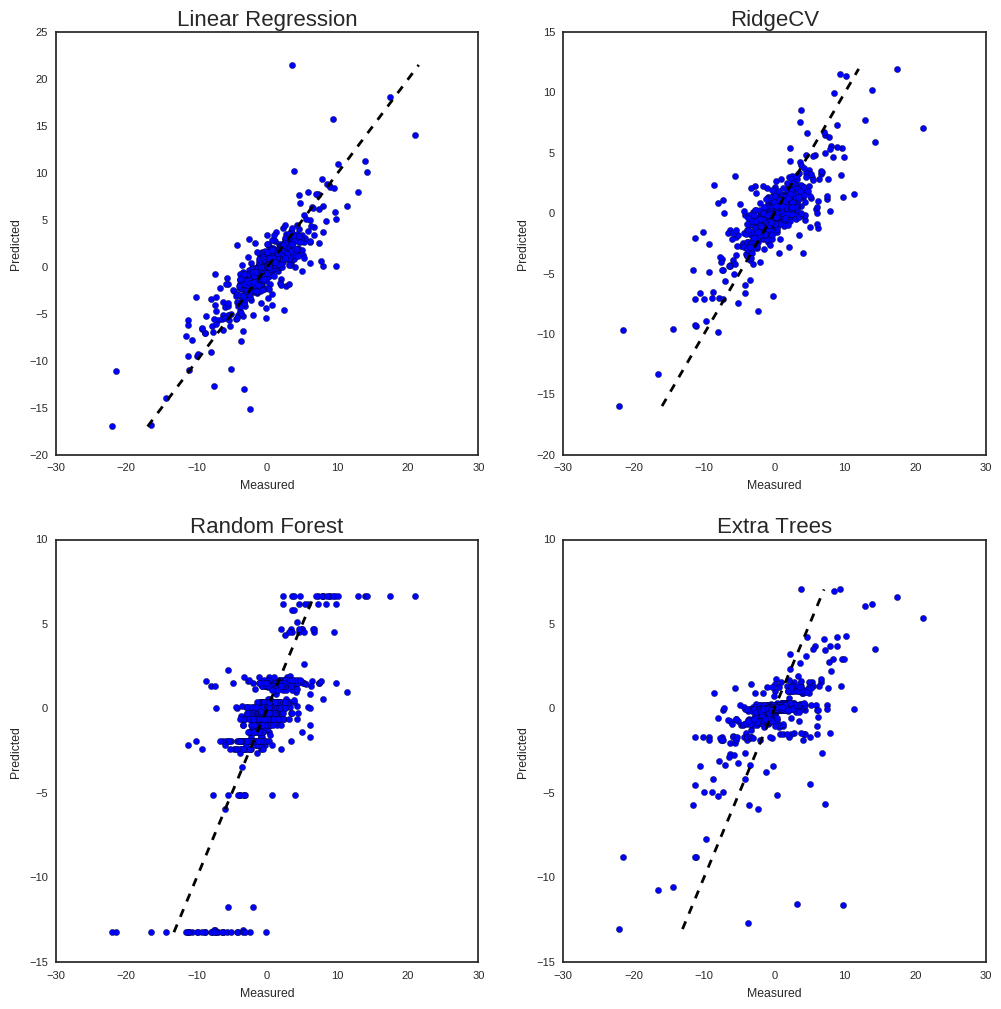

In [26]:
all_sectors = {}
for sector, symbols in sector_symbols.iteritems():
    sector_news = has_news[(has_news.Symbol.isin(sector_symbols[sector]))]

    sec_x = sector_news[['Close', 'High', 'Low', 'Open', 'Volume', 'compound',
                         'neg', 'neu', 'pos', 'Next_Open', 'Prev_Slope']]
    sec_y = sector_news['Diff_Slope']
    sec_x_train, sec_x_test, sec_y_train, sec_y_test=train_test_split(sec_x, sec_y, test_size=0.3)
    print sector

    filename = 'datasets/models/{}.sav'.format(sector.replace(' ', '_'))

    sec_dic = {}
    if os.path.exists(filename):
        sec_dic = joblib.load(filename)
    else:
        sec_dic['lr_model'], sec_dic['lr_report'] = slr.linear_regression(sec_x_train, sec_y_train)
        sec_dic['rd_model'], sec_dic['rd_report'] = slr.ridge_cv(sec_x_train, sec_y_train)
        sec_dic['rf_model'], sec_dic['rf_report'] = slr.random_forest(sec_x_train, sec_y_train)
        sec_dic['et_model'], sec_dic['et_report'] = slr.extra_trees(sec_x_train, sec_y_train)
        joblib.dump(sec_dic, filename)
        
    sec_dic['size'] = sec_x.shape[0]
    sec_dic['lr_score'] = sec_dic['lr_model'].score(sec_x_test, sec_y_test)
    sec_dic['rd_score'] = sec_dic['rd_model'].score(sec_x_test, sec_y_test)
    sec_dic['rf_score'] = sec_dic['rf_model'].score(sec_x_test, sec_y_test)
    sec_dic['et_score'] = sec_dic['et_model'].score(sec_x_test, sec_y_test)

    print sec_dic['size']
    all_sectors[sector] = sec_dic
    
#     print print_comparisions(sec_y_test, sec_x_test,
#                              sec_dic['lr_model'],
#                              sec_dic['rd_model'],
#                              sec_dic['rf_model'],
#                              sec_dic['et_model'],
#                              title = sector
#                      )
    slr.plot_comparisions(sec_y_test,
                      sec_dic['lr_model'].predict(sec_x_test),
                      sec_dic['rd_model'].predict(sec_x_test),
                      sec_dic['rf_model'].predict(sec_x_test),
                      sec_dic['et_model'].predict(sec_x_test)
                     )

In [27]:
sector_report = pd.DataFrame(all_sectors)
sector_report

,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Telecommunications Services,Utilities
et_model,"(ExtraTreeRegressor(criterion='mse', max_depth...","(ExtraTreeRegressor(criterion='mse', max_depth...","(ExtraTreeRegressor(criterion='mse', max_depth...","(ExtraTreeRegressor(criterion='mse', max_depth...","(ExtraTreeRegressor(criterion='mse', max_depth...","(ExtraTreeRegressor(criterion='mse', max_depth...","(ExtraTreeRegressor(criterion='mse', max_depth...","(ExtraTreeRegressor(criterion='mse', max_depth...","(ExtraTreeRegressor(criterion='mse', max_depth...","(ExtraTreeRegressor(criterion='mse', max_depth...","(ExtraTreeRegressor(criterion='mse', max_depth..."
et_report,{u'Mean cross validation score': 0.54496740039...,{u'Mean cross validation score': 0.54240378645...,{u'Mean cross validation score': 0.44284167639...,{u'Mean cross validation score': 0.01027704786...,{u'Mean cross validation score': 0.30963355709...,{u'Mean cross validation score': 0.49857224482...,{u'Mean cross validation score': 0.60040385851...,{u'Mean cross validation score': 0.63290252908...,{u'Mean cross validation score': 0.31664786715...,{u'Mean cross validation score': 0.59844161366...,{u'Mean cross validation score': 0.47515594565...
et_score,0.503628,0.592502,0.477481,0.365785,0.549808,0.550646,0.884236,0.549887,0.262131,0.426139,0.396641
lr_model,"LinearRegression(copy_X=True, fit_intercept=Fa...","LinearRegression(copy_X=True, fit_intercept=Fa...","LinearRegression(copy_X=True, fit_intercept=Fa...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Fa...","LinearRegression(copy_X=True, fit_intercept=Fa...","LinearRegression(copy_X=True, fit_intercept=Fa...","LinearRegression(copy_X=True, fit_intercept=Fa...","LinearRegression(copy_X=True, fit_intercept=Fa...","LinearRegression(copy_X=True, fit_intercept=Tr...","LinearRegression(copy_X=True, fit_intercept=Fa..."
lr_report,{u'Mean cross validation score': 0.88078964571...,{u'Mean cross validation score': 0.83675978832...,{u'Mean cross validation score': 0.68658351884...,{u'Mean cross validation score': 0.71194035834...,{u'Mean cross validation score': 0.74608630623...,{u'Mean cross validation score': 0.71692404412...,{u'Mean cross validation score': 0.90618103203...,{u'Mean cross validation score': 0.70723270499...,{u'Mean cross validation score': 0.60896596650...,{u'Mean cross validation score': 0.56155039562...,{u'Mean cross validation score': 0.56602913191...
lr_score,0.747335,0.831555,0.7272,0.708191,0.831699,0.802979,0.96305,0.713603,0.266121,0.684644,0.541112
rd_model,"RidgeCV(alphas=[0.1, 0.5, 1.0, 5.0, 10.0, 100....","RidgeCV(alphas=[0.1, 0.5, 1.0, 5.0, 10.0, 100....","RidgeCV(alphas=[0.1, 0.5, 1.0, 5.0, 10.0, 100....","RidgeCV(alphas=[0.1, 0.5, 1.0, 5.0, 10.0, 100....","RidgeCV(alphas=[0.1, 0.5, 1.0, 5.0, 10.0, 100....","RidgeCV(alphas=[0.1, 0.5, 1.0, 5.0, 10.0, 100....","RidgeCV(alphas=[0.1, 0.5, 1.0, 5.0, 10.0, 100....","RidgeCV(alphas=[0.1, 0.5, 1.0, 5.0, 10.0, 100....","RidgeCV(alphas=[0.1, 0.5, 1.0, 5.0, 10.0, 100....","RidgeCV(alphas=[0.1, 0.5, 1.0, 5.0, 10.0, 100....","RidgeCV(alphas=[0.1, 0.5, 1.0, 5.0, 10.0, 100...."
rd_report,{u'Mean cross validation score': 0.52373051465...,{u'Mean cross validation score': 0.74040401159...,{u'Mean cross validation score': 0.48004153991...,{u'Mean cross validation score': 0.51521617026...,{u'Mean cross validation score': 0.50475503078...,{u'Mean cross validation score': 0.54550022379...,{u'Mean cross validation score': 0.41649282792...,{u'Mean cross validation score': 0.65166142084...,{u'Mean cross validation score': 0.36355068648...,{u'Mean cross validation score': 0.60949173246...,{u'Mean cross validation score': 0.48390636544...
rd_score,0.585816,0.65913,0.520141,0.622942,0.661327,0.586947,0.90233,0.58784,0.226481,0.478633,0.387196
rf_model,"(DecisionTreeRegressor(criterion='mse', max_de...","(DecisionTreeRegressor(criterio

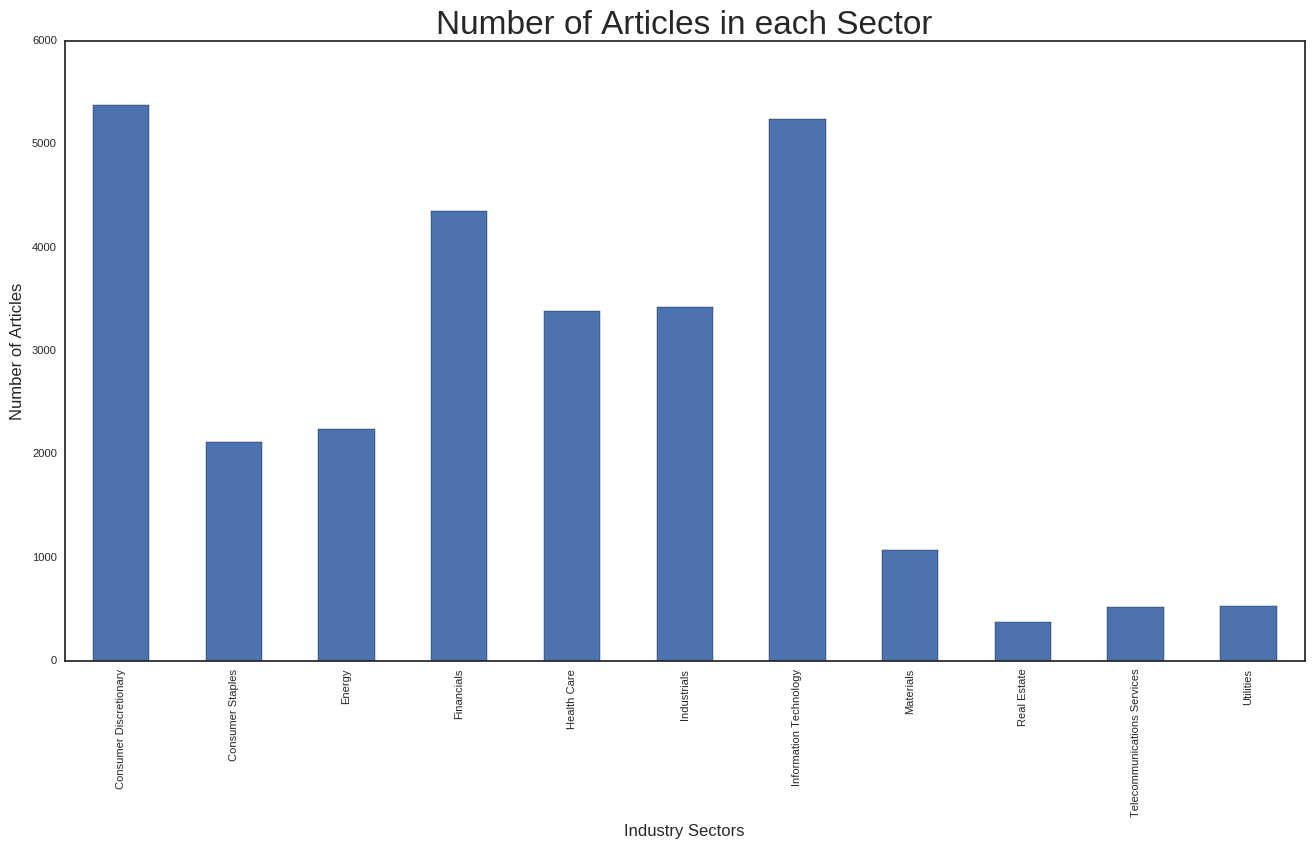

In [28]:
slr.set_style()
ax = sector_report.loc['size', :].plot.bar(figsize=(16, 8))
ax.set_ylabel("Number of Articles", fontsize=12)
ax.set_xlabel("Industry Sectors", fontsize=12)
ax.set_title('Number of Articles in each Sector', fontsize=24)

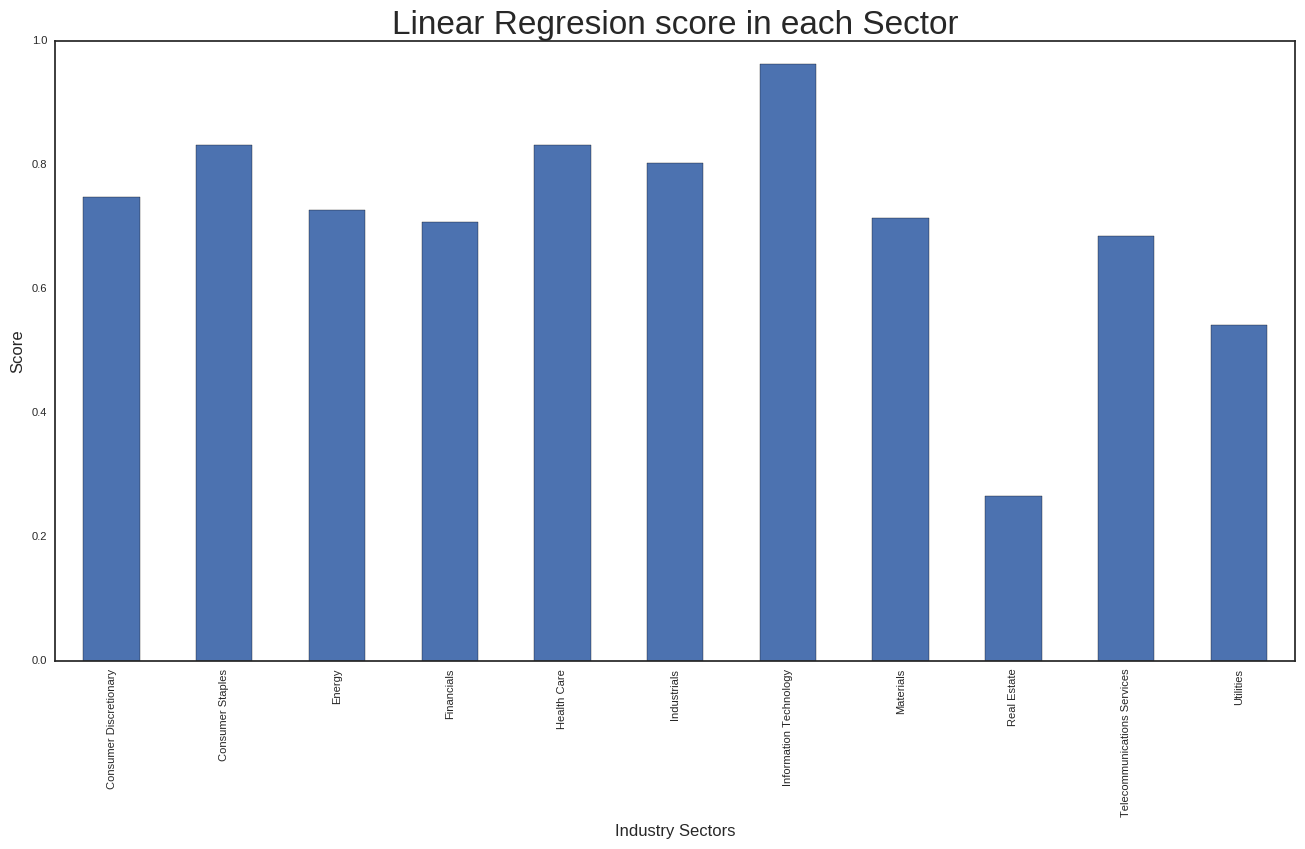

In [29]:
slr.set_style()
ax = sector_report.loc['lr_score', :].plot.bar(figsize=(16, 8))
ax.set_ylabel("Score", fontsize=12)
ax.set_xlabel("Industry Sectors", fontsize=12)
ax.set_title('Linear Regresion score in each Sector', fontsize=24)

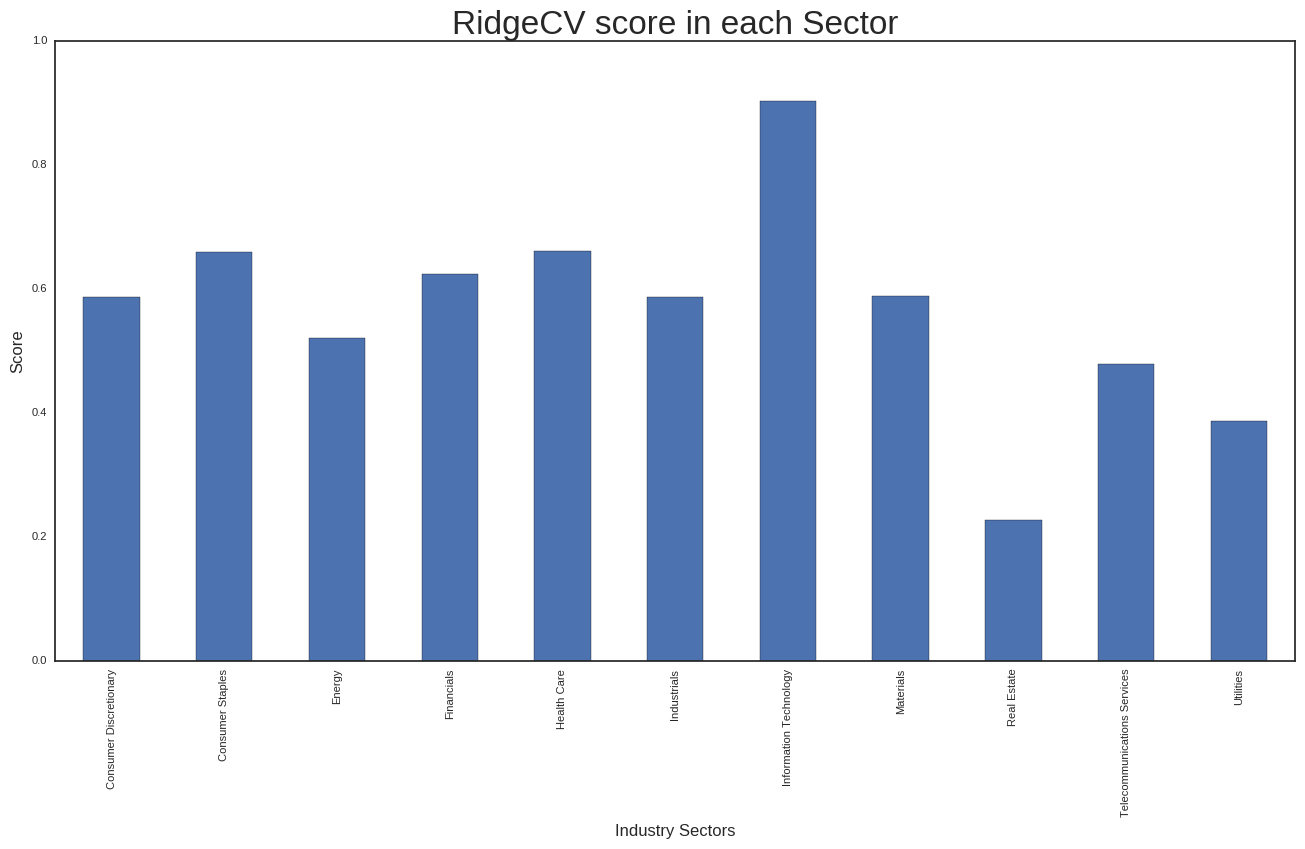

In [30]:
slr.set_style()
ax = sector_report.loc['rd_score', :].plot.bar(figsize=(16, 8))
ax.set_ylabel("Score", fontsize=12)
ax.set_xlabel("Industry Sectors", fontsize=12)
ax.set_title('RidgeCV score in each Sector', fontsize=24)

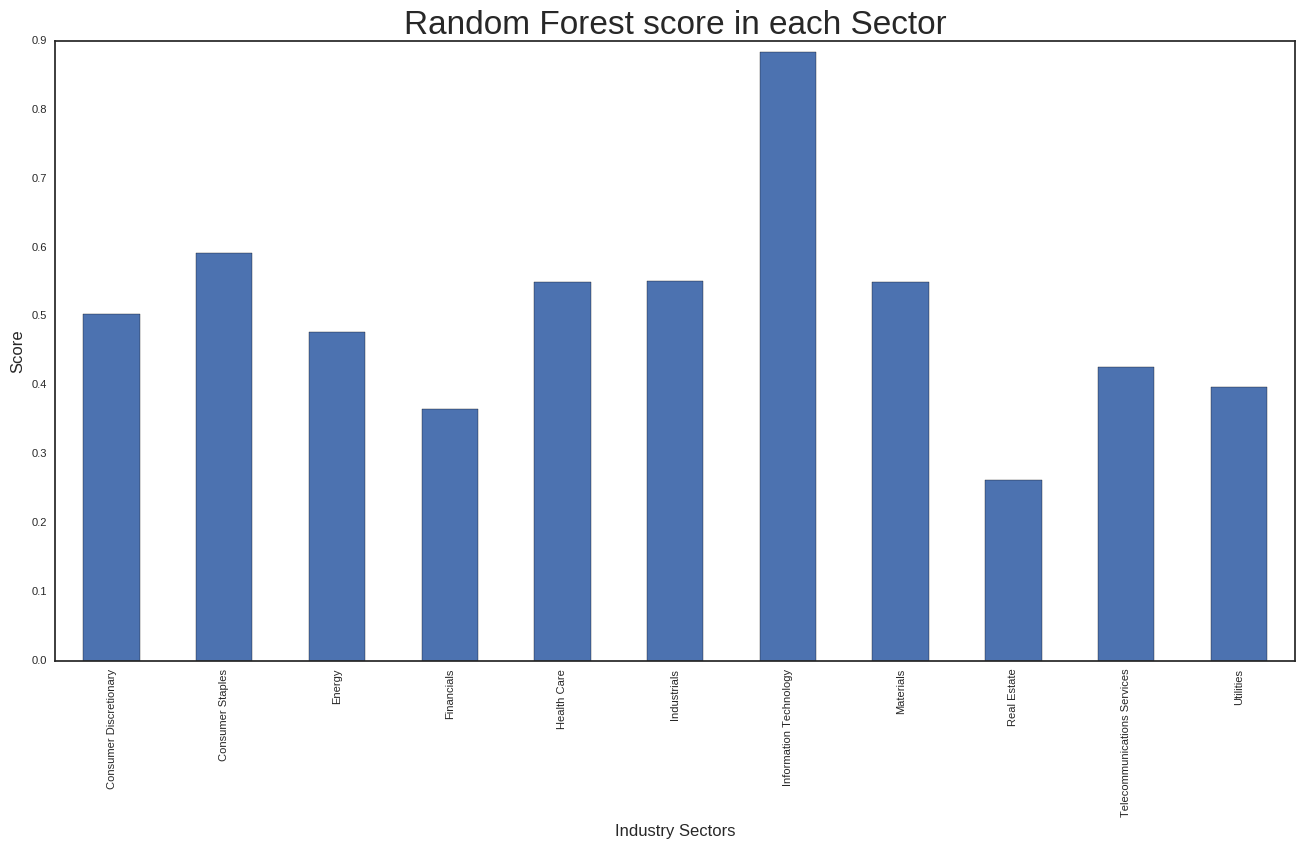

In [31]:
slr.set_style()
ax = sector_report.loc['et_score', :].plot.bar(figsize=(16, 8))
ax.set_ylabel("Score", fontsize=12)
ax.set_xlabel("Industry Sectors", fontsize=12)
ax.set_title('Random Forest score in each Sector', fontsize=24)

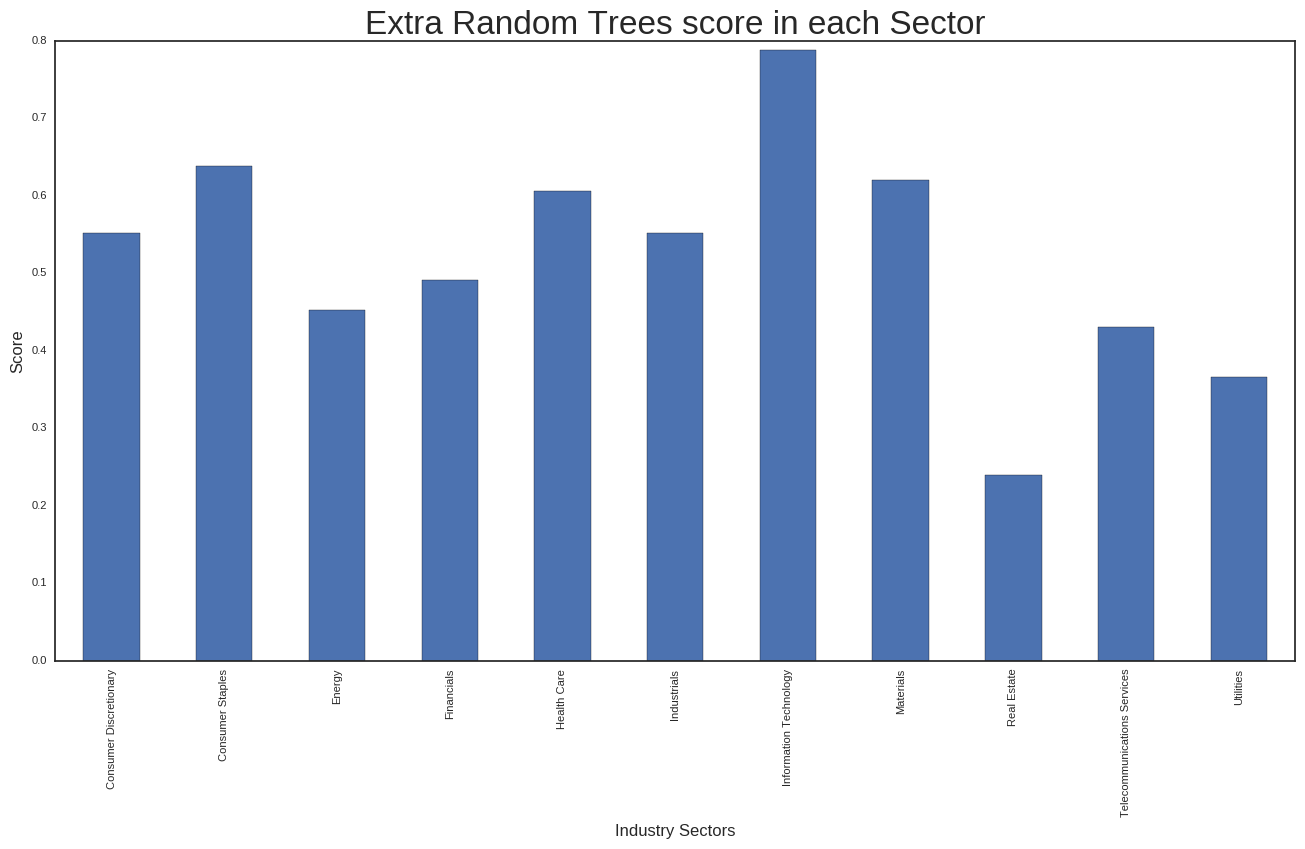

In [32]:
slr.set_style()
ax = sector_report.loc['rf_score', :].plot.bar(figsize=(16, 8))
ax.set_ylabel("Score", fontsize=12)
ax.set_xlabel("Industry Sectors", fontsize=12)
ax.set_title('Extra Random Trees score in each Sector', fontsize=24)

In [33]:
lr_means = pd.DataFrame(
    [[key, ms['Mean cross validation score']] for key, ms in sector_report.loc['lr_report', :].iteritems()],
    columns=['sectors', 'lr'])

rd_means = pd.DataFrame(
    [[key, ms['Mean cross validation score']] for key, ms in sector_report.loc['rd_report', :].iteritems()])
rf_means = pd.DataFrame(
    [[key, ms['Mean cross validation score']] for key, ms in sector_report.loc['rf_report', :].iteritems()])
et_means = pd.DataFrame(
    [[key, ms['Mean cross validation score']] for key, ms in sector_report.loc['et_report', :].iteritems()])
means = pd.concat([lr_means, rd_means, rf_means, et_means], axis=1).drop(0, axis=1).set_index('sectors')
means.columns = ['Linear Regression', 'RidgeCV', 'Random Forest', 'Extra Trees']
means

,Linear Regression,RidgeCV,Random Forest,Extra Trees
sectors,,,,
Consumer Discretionary,0.880790,0.523731,0.405523,0.544967
Consumer Staples,0.836760,0.740404,0.651594,0.542404
Energy,0.686584,0.480042,0.436159,0.442842
Financials,0.711940,0.515216,0.263430,0.010277
Health Care,0.746086,0.504755,0.394222,0.309634
Industrials,0.716924,0.545500,0.543665,0.498572
Information Technology,0.906181,0.416493,0.278533,0.600404
Materials,0.707233,0.651661,0.514669,0.632903
Real Estate,0.608966,0.363551,0.292438,0.316648


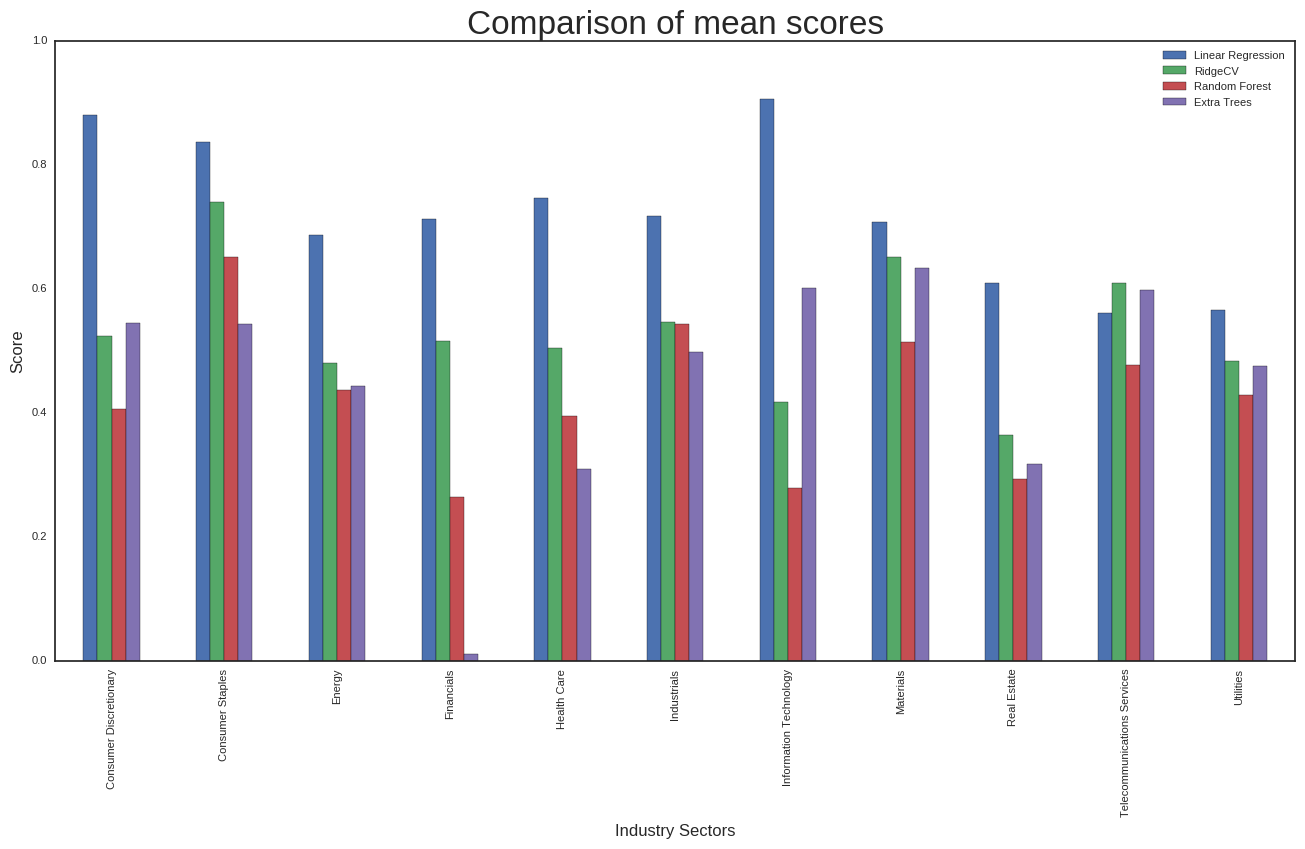

In [34]:
# means.plot.bar()
slr.set_style()
ax = means.plot.bar(figsize=(16, 8))
ax.set_ylabel("Score", fontsize=12)
ax.set_xlabel("Industry Sectors", fontsize=12)
ax.set_title('Comparison of mean scores', fontsize=24)
